In [4]:
#Importing packages
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras import backend as K
import itertools
#from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras.layers.core import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,AveragePooling2D, Flatten, Dropout, Input, BatchNormalization
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix)

In [5]:
!pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 593.0 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rfpimp 1.3.2 requires sklearn, which is not installed.
wrf-python 1.3.4.1 requires basemap, which is not installed.
altair 5.2.0 requires typing-extensions>=4.0.1; python_version < "3.11", but you have typing-extensions 3.7.4.3 which is incompatible.
bokeh 2.4.3 requires typing-extensions>=3.10.0, but you have typing-extensions 3.7.4.3 which is incompatible.
pandas 1.5.3 requires numpy>=1.20.3, but you have numpy 1.20.0 which is incompatible.
pingouin 0.5.2 requires scikit-learn<1.1.0, but you have scikit-

In [7]:
import torch

# Data pre-processing

In [22]:
path = '/Users/kipkemoivincent/Desktop/Covid/Data2'

In [37]:
IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE= 7023

horizontal_flip=True, 
                                                               vertical_flip=True,zoom_range=0.3,

In [38]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,validation_split=0.0001)
train_generator = train_datagen.flow_from_directory(path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset='training')

Found 7023 images belonging to 4 classes.


In [27]:
validation_generator = train_datagen.flow_from_directory(path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=743,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   subset='validation')

Found 0 images belonging to 4 classes.


In [39]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : glioma
1 : meningioma
2 : notumor
3 : pituitary


In [29]:
#!pip install numpy==1.20

In [40]:
def report(arr1,arr2):
    print ('\x1b[6;30;46m'+'Accuracy:'+str(np.round(accuracy_score(arr1, arr2),4))+','+' Precision:'+str(np.round(precision_score(arr1, arr2),4))+','+
    ' Recall:'+str(np.round(recall_score(arr1, arr2),4))+','+' F1_score:'+str(np.round(f1_score(arr1, arr2),4)))
    return              

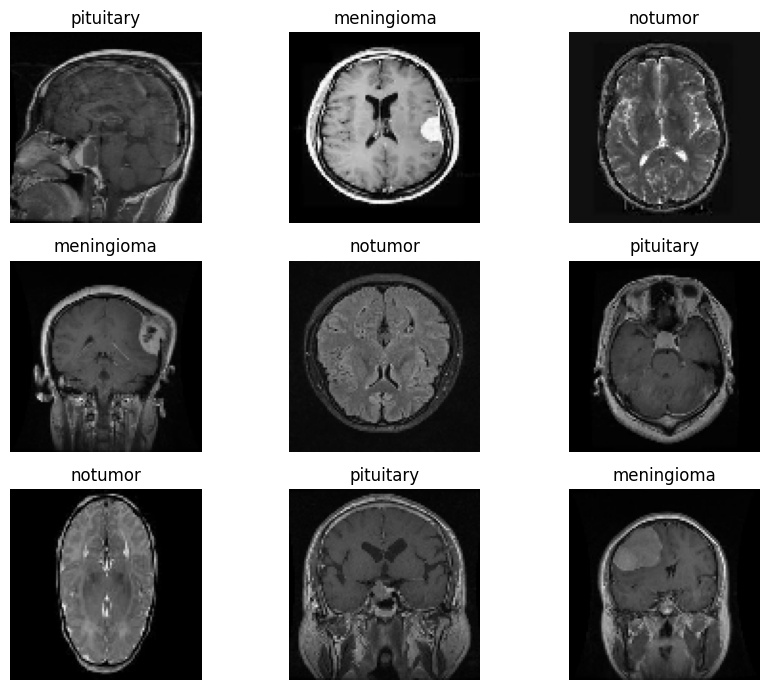

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 7)) 
idx = 0

for i in range(3): 
    for j in range(3): 
        label = labels[np.argmax(train_generator[0][1][idx])] 
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :]) 
        ax[i, j].axis("off") 
        idx += 1

plt.tight_layout() 
#plt.suptitle("Sample Training Images", fontsize=21) 
plt.show()

In [41]:
X, y = next(train_generator)
X=(X-X.mean())/X.std()
#X_test, y_test = next(validation_generator)

In [42]:
from sklearn.model_selection import train_test_split
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.20, random_state=42, shuffle=True)

In [44]:
X_train.shape,X_val.shape, X_test.shape

((5056, 100, 100, 3), (1264, 100, 100, 3), (703, 100, 100, 3))

In [45]:
IMPUT_SHAPE=(IMG_WIDTH, IMG_HEIGHT, 3)

# Prediction using different Architectures

# A. CustomCNN

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
initializer = tf.keras.initializers.HeNormal()
values = initializer(shape=(2, 2))

In [53]:
from sklearn.utils import compute_class_weight
y=[np.argmax(i) for i in y_train]
class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y),y = y)
class_weights = dict(zip(np.unique(y), class_weights))

In [54]:
input_data = Input(shape=IMPUT_SHAPE)

#Convolution
x = Conv2D(32, (3, 3), activation="relu")(input_data)

#Pooling
x = MaxPooling2D(pool_size = (4, 4), strides=(4, 4))(x)

#Dropout
x = Dropout(0.25)(x)

# 2nd Convolution
x = Conv2D(32, (3, 3), activation="relu")(x)

# 2nd Pooling layer
x = MaxPooling2D(pool_size = (2, 2))(x)

#Dropout
x = Dropout(0.3)(x)

#3rd Convolution
x = Conv2D(32, (3, 3), activation='relu')(x)

#3rd Pooling Layer
x = MaxPooling2D(pool_size=(2, 2))(x)

#Dropout
x = Dropout(0.3)(x)

# Flatten the layer
x = Flatten()(x)

# Fully Connected Layers
x =Dense(128, activation = 'relu')(x)
output = Dense(4, activation = 'softmax')(x)

cnn =keras.models.Model(inputs=input_data, outputs=output)

# Compile the Neural network
cnn.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [55]:
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 11, 11, 32)        0   

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
filepath11="weights.best_custom_cnn2.hdf5"
checkpoint1 = ModelCheckpoint(filepath11, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=20)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list = [checkpoint1,es,rlrop]

In [57]:
history1 = cnn.fit(X_train,y_train,epochs = 100,verbose = 1,batch_size=4,
                  validation_data =(X_test,y_test),callbacks=callbacks_list,
                 class_weight=class_weights)

Epoch 1/100
1264/1264 [==============================] - 24s 19ms/step - loss: 1.2916 - accuracy: 0.4375 - val_loss: 0.8828 - val_accuracy: 0.6714

Epoch 00001: val_accuracy improved from -inf to 0.67141, saving model to weights.best_custom_cnn2.hdf5
Epoch 2/100
1264/1264 [==============================] - 24s 19ms/step - loss: 0.8651 - accuracy: 0.6635 - val_loss: 0.7001 - val_accuracy: 0.7710

Epoch 00002: val_accuracy improved from 0.67141 to 0.77098, saving model to weights.best_custom_cnn2.hdf5
Epoch 3/100
1264/1264 [==============================] - 25s 20ms/step - loss: 0.7360 - accuracy: 0.7175 - val_loss: 0.6294 - val_accuracy: 0.7553

Epoch 00003: val_accuracy did not improve from 0.77098
Epoch 4/100
1264/1264 [==============================] - 24s 19ms/step - loss: 0.6538 - accuracy: 0.7470 - val_loss: 0.5994 - val_accuracy: 0.7411

Epoch 00004: val_accuracy did not improve from 0.77098
Epoch 5/100
1264/1264 [==============================] - 24s 19ms/step - loss: 0.6164 - a


Epoch 00036: val_accuracy did not improve from 0.94879
Epoch 37/100
1264/1264 [==============================] - 25s 20ms/step - loss: 0.1790 - accuracy: 0.9312 - val_loss: 0.1583 - val_accuracy: 0.9403

Epoch 00037: val_accuracy did not improve from 0.94879
Epoch 38/100
1264/1264 [==============================] - 25s 20ms/step - loss: 0.1548 - accuracy: 0.9408 - val_loss: 0.1555 - val_accuracy: 0.9459

Epoch 00038: val_accuracy did not improve from 0.94879
Epoch 39/100
1264/1264 [==============================] - 25s 19ms/step - loss: 0.1643 - accuracy: 0.9402 - val_loss: 0.1590 - val_accuracy: 0.9445

Epoch 00039: val_accuracy did not improve from 0.94879
Epoch 40/100
1264/1264 [==============================] - 25s 20ms/step - loss: 0.1487 - accuracy: 0.9458 - val_loss: 0.1611 - val_accuracy: 0.9459

Epoch 00040: val_accuracy did not improve from 0.94879
Epoch 41/100
1264/1264 [==============================] - 28s 22ms/step - loss: 0.1403 - accuracy: 0.9483 - val_loss: 0.1541 - v

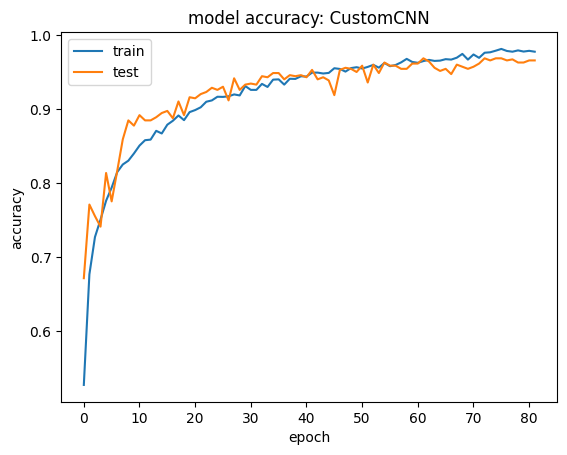

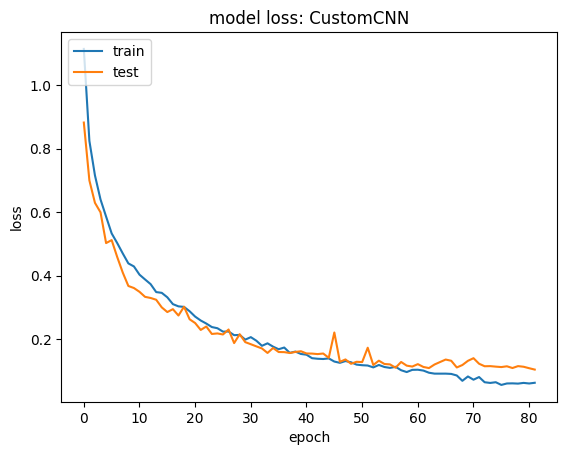

In [58]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy: CustomCNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss: CustomCNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
# load the saved model
from keras.models import load_model
cnn=load_model('weights.best_custom_cnn2.hdf5')

In [106]:
pred1=cnn.predict(X_test)

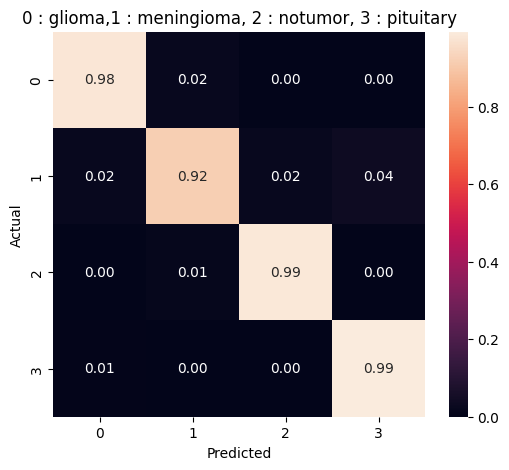

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0 : glioma,1 : meningioma, 2 : notumor, 3 : pituitary')
plt.show(block=False)

In [103]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "customCNN1.h5")
# load and evaluate a saved model
loaded_model = models.load_model('customCNN1.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

# B. MobileNetV2 

In [64]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def make_mobilenet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
# Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(4, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [65]:
filepath21="weights.best_mobile_net2.hdf5"
checkpoint2 = ModelCheckpoint(filepath21, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es2 = EarlyStopping(monitor='val_accuracy', patience=20)
rlrop2 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list2 = [checkpoint2,es2,rlrop2]

In [66]:
# Define a model using the make_model function
image_size = (100,100,3)
mobilenet_model = make_mobilenet_model(image_size, num_classes = 2)

# Preview the Model Summary
mobilenet_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516 

In [67]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']

mobilenet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [68]:
history2= mobilenet_model.fit(X_train, y_train,batch_size = 4, epochs = 100, validation_data = (X_val, y_val), 
                                                callbacks=callbacks_list2, class_weight=class_weights)

Epoch 1/100
1264/1264 [==============================] - 45s 34ms/step - loss: 1.0274 - accuracy: 0.6334 - val_loss: 0.4062 - val_accuracy: 0.8465

Epoch 00001: val_accuracy improved from -inf to 0.84652, saving model to weights.best_mobile_net2.hdf5
Epoch 2/100
1264/1264 [==============================] - 51s 40ms/step - loss: 0.4607 - accuracy: 0.8346 - val_loss: 0.3407 - val_accuracy: 0.8758

Epoch 00002: val_accuracy improved from 0.84652 to 0.87579, saving model to weights.best_mobile_net2.hdf5
Epoch 3/100
1264/1264 [==============================] - 45s 35ms/step - loss: 0.3998 - accuracy: 0.8558 - val_loss: 0.3144 - val_accuracy: 0.8869

Epoch 00003: val_accuracy improved from 0.87579 to 0.88687, saving model to weights.best_mobile_net2.hdf5
Epoch 4/100
1264/1264 [==============================] - 51s 41ms/step - loss: 0.3252 - accuracy: 0.8820 - val_loss: 0.2843 - val_accuracy: 0.8900

Epoch 00004: val_accuracy improved from 0.88687 to 0.89003, saving model to weights.best_mobi


Epoch 00036: val_accuracy did not improve from 0.94858
Epoch 37/100
1264/1264 [==============================] - 47s 37ms/step - loss: 0.0555 - accuracy: 0.9821 - val_loss: 0.1580 - val_accuracy: 0.9430

Epoch 00037: val_accuracy did not improve from 0.94858
Epoch 38/100
1264/1264 [==============================] - 52s 41ms/step - loss: 0.0466 - accuracy: 0.9867 - val_loss: 0.1595 - val_accuracy: 0.9502

Epoch 00038: val_accuracy improved from 0.94858 to 0.95016, saving model to weights.best_mobile_net2.hdf5
Epoch 39/100
1264/1264 [==============================] - 45s 35ms/step - loss: 0.0509 - accuracy: 0.9825 - val_loss: 0.1641 - val_accuracy: 0.9446

Epoch 00039: val_accuracy did not improve from 0.95016
Epoch 40/100
1264/1264 [==============================] - 58s 46ms/step - loss: 0.0464 - accuracy: 0.9832 - val_loss: 0.1794 - val_accuracy: 0.9446

Epoch 00040: val_accuracy did not improve from 0.95016
Epoch 41/100
1264/1264 [==============================] - 48s 38ms/step - los


Epoch 00075: val_accuracy did not improve from 0.95332
Epoch 76/100
1264/1264 [==============================] - 53s 42ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.1881 - val_accuracy: 0.9517

Epoch 00076: val_accuracy did not improve from 0.95332
Epoch 77/100
1264/1264 [==============================] - 43s 34ms/step - loss: 0.0142 - accuracy: 0.9970 - val_loss: 0.1753 - val_accuracy: 0.9533

Epoch 00077: val_accuracy did not improve from 0.95332
Epoch 78/100
1264/1264 [==============================] - 54s 43ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.1721 - val_accuracy: 0.9533

Epoch 00078: val_accuracy did not improve from 0.95332
Epoch 79/100
1264/1264 [==============================] - 44s 35ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.1701 - val_accuracy: 0.9525

Epoch 00079: val_accuracy did not improve from 0.95332
Epoch 80/100
1264/1264 [==============================] - 52s 41ms/step - loss: 0.0115 - accuracy: 0.9975 - val_loss: 0.1686 - v

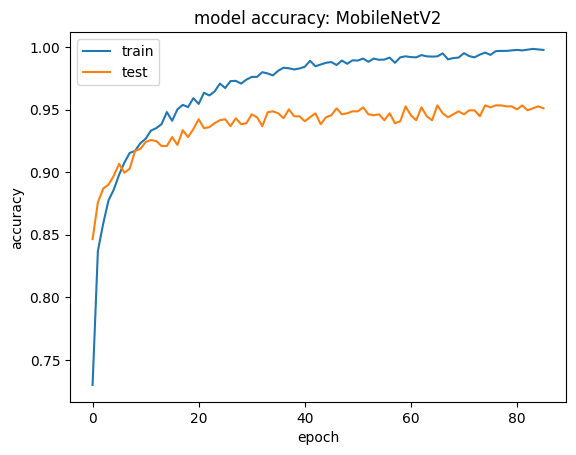

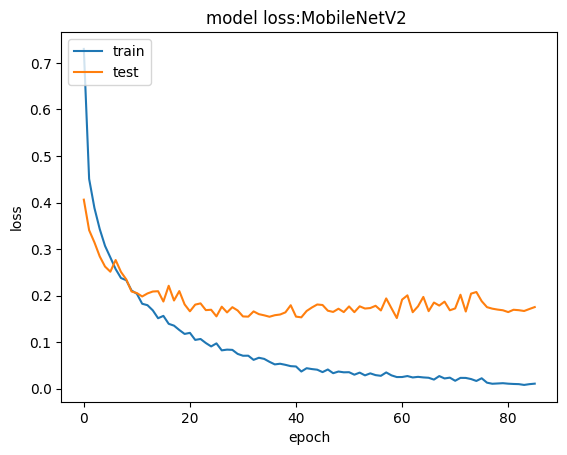

In [69]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy: MobileNetV2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss:MobileNetV2 ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [104]:
mobilenet_model=load_model('weights.best_mobile_net2.hdf5')

In [107]:
pred2=mobilenet_model.predict(X_test)

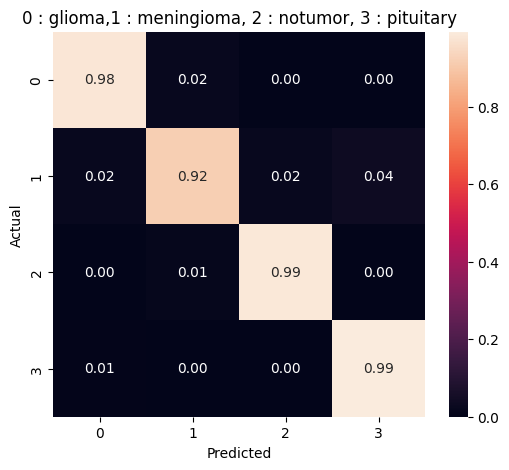

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0 : glioma,1 : meningioma, 2 : notumor, 3 : pituitary')
plt.show(block=False)

In [72]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "Mobilenetv2.h5")
# load and evaluate a saved model
loaded_model = models.load_model('Mobilenetv2.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

# C: DenseNet169

In [73]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [74]:
from tensorflow.keras.applications import DenseNet169

In [78]:
def make_densenet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.DenseNet169(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    # Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(4, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [79]:
image_size = (100,100,3)
densenet_model = make_densenet_model(image_size, num_classes = 2)

# Preview the Model Summary
densenet_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 3, 3, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1664)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               213120    
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516 

In [80]:
filepath31="weights.best_densenet1692.hdf5"
checkpoint3 = ModelCheckpoint(filepath31, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es3 = EarlyStopping(monitor='val_accuracy', patience=20)
rlrop3 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list3 = [checkpoint3,es3,rlrop3]

In [81]:
densenet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [84]:
history3 = densenet_model.fit(X_train, y_train,epochs = 100,verbose = 1,batch_size=2,validation_data =(X_val,y_val)
                    ,callbacks=callbacks_list3,class_weight=class_weights)

Epoch 1/100
2528/2528 [==============================] - 229s 90ms/step - loss: 0.4918 - accuracy: 0.8218 - val_loss: 0.3327 - val_accuracy: 0.8774

Epoch 00001: val_accuracy improved from -inf to 0.87737, saving model to weights.best_densenet1692.hdf5
Epoch 2/100
2528/2528 [==============================] - 243s 96ms/step - loss: 0.3994 - accuracy: 0.8513 - val_loss: 0.3493 - val_accuracy: 0.8608

Epoch 00002: val_accuracy did not improve from 0.87737
Epoch 3/100
2528/2528 [==============================] - 245s 97ms/step - loss: 0.3589 - accuracy: 0.8645 - val_loss: 0.2915 - val_accuracy: 0.8837

Epoch 00003: val_accuracy improved from 0.87737 to 0.88370, saving model to weights.best_densenet1692.hdf5
Epoch 4/100
2528/2528 [==============================] - 234s 92ms/step - loss: 0.3055 - accuracy: 0.8859 - val_loss: 0.2871 - val_accuracy: 0.8979

Epoch 00004: val_accuracy improved from 0.88370 to 0.89794, saving model to weights.best_densenet1692.hdf5
Epoch 5/100
2528/2528 [========

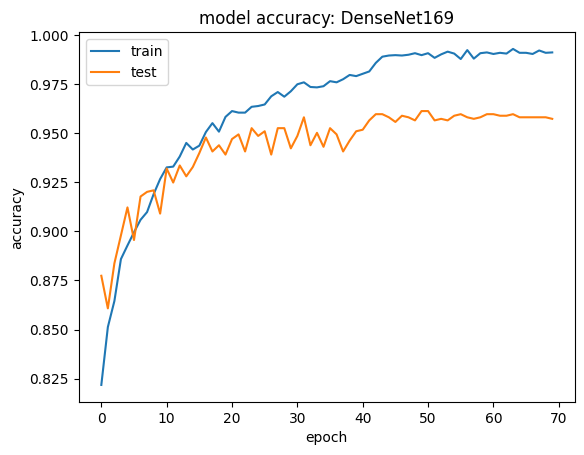

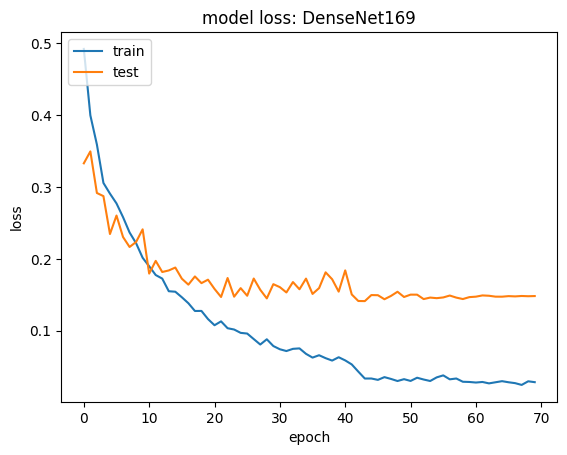

In [85]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy: DenseNet169')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss: DenseNet169')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [108]:
model=load_model('weights.best_densenet1692.hdf5')

In [117]:
pred3=model.predict(X_test)

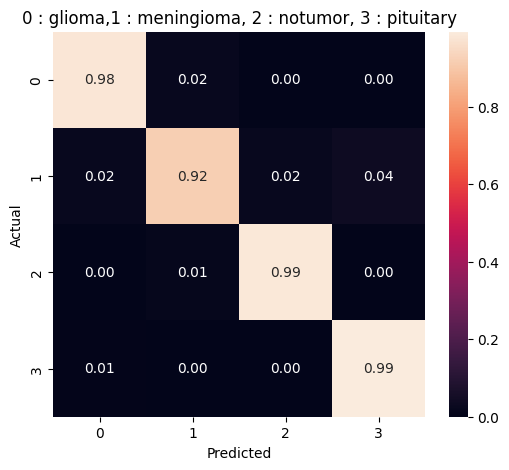

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0 : glioma,1 : meningioma, 2 : notumor, 3 : pituitary')
plt.show(block=False)

In [88]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "DenseNet1692.h5")
# load and evaluate a saved model
loaded_model = models.load_model('DenseNet1692.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

# D: ResNet50

In [89]:
def make_resnet_model(image_size, num_classes):
    
    input_shape = image_size 
    
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # Do not include the dense prediction layer
                                                   weights="imagenet") # Load imageNet parameters
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = inputs
     
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    # Fully Connected Layers
    x =Dense(128, activation = 'relu')(x)  
   
    prediction_layer = Dense(4, activation='softmax')
    
    outputs = prediction_layer(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [90]:
image_size = (100,100,3)
resnet_model = make_resnet_model(image_size, num_classes = 2)

# Preview the Model Summary
resnet_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516 

In [91]:
filepath51="weights.best_ResNet502.hdf5"
checkpoint4 = ModelCheckpoint(filepath51, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es4 = EarlyStopping(monitor='val_accuracy', patience=20)
rlrop4 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
callbacks_list4 = [checkpoint4,es4,rlrop4]

In [92]:
base_learning_rate = 0.001
optimizer = Adam(learning_rate = base_learning_rate)
initial_epochs = 50
batch_size = 64
loss = 'categorical_crossentropy'
metrics = ['accuracy']

resnet_model.compile(optimizer =Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [93]:
history4 = resnet_model.fit(X_train, y_train,epochs = 100,verbose = 1,batch_size=2,validation_data =(X_val,y_val)
                    ,callbacks=callbacks_list4,class_weight=class_weights)

Epoch 1/100
2528/2528 [==============================] - 283s 110ms/step - loss: 1.0110 - accuracy: 0.5737 - val_loss: 0.5416 - val_accuracy: 0.8062

Epoch 00001: val_accuracy improved from -inf to 0.80617, saving model to weights.best_ResNet502.hdf5
Epoch 2/100
2528/2528 [==============================] - 2463s 975ms/step - loss: 0.6110 - accuracy: 0.7605 - val_loss: 0.4703 - val_accuracy: 0.8228

Epoch 00002: val_accuracy improved from 0.80617 to 0.82278, saving model to weights.best_ResNet502.hdf5
Epoch 3/100
2528/2528 [==============================] - 334s 132ms/step - loss: 0.5222 - accuracy: 0.7965 - val_loss: 0.4245 - val_accuracy: 0.8347

Epoch 00003: val_accuracy improved from 0.82278 to 0.83465, saving model to weights.best_ResNet502.hdf5
Epoch 4/100
2528/2528 [==============================] - 556s 220ms/step - loss: 0.4793 - accuracy: 0.8174 - val_loss: 0.3879 - val_accuracy: 0.8536

Epoch 00004: val_accuracy improved from 0.83465 to 0.85364, saving model to weights.best_R

2528/2528 [==============================] - 292s 115ms/step - loss: 0.1524 - accuracy: 0.9436 - val_loss: 0.2165 - val_accuracy: 0.9280

Epoch 00076: val_accuracy did not improve from 0.93038
Epoch 77/100
2528/2528 [==============================] - 293s 116ms/step - loss: 0.1469 - accuracy: 0.9454 - val_loss: 0.2166 - val_accuracy: 0.9280

Epoch 00077: val_accuracy did not improve from 0.93038
Epoch 78/100
2528/2528 [==============================] - 304s 120ms/step - loss: 0.1406 - accuracy: 0.9444 - val_loss: 0.2166 - val_accuracy: 0.9272

Epoch 00078: val_accuracy did not improve from 0.93038


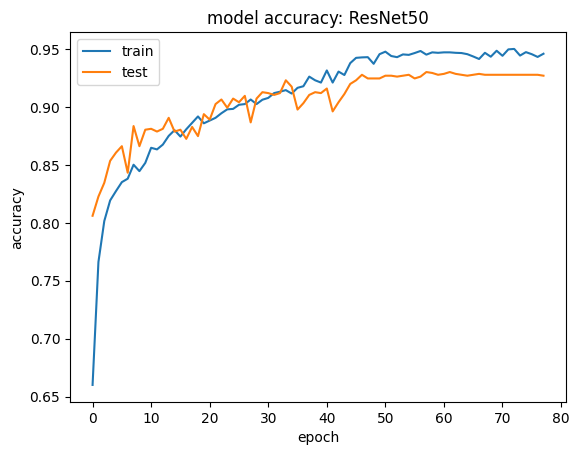

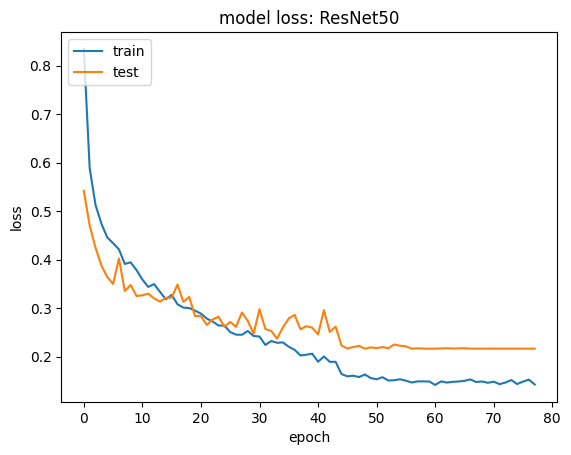

In [94]:
# summarize history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy: ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss: ResNet50')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [110]:
model=load_model('weights.best_ResNet502.hdf5')

In [111]:
pred4=model.predict(X_test)

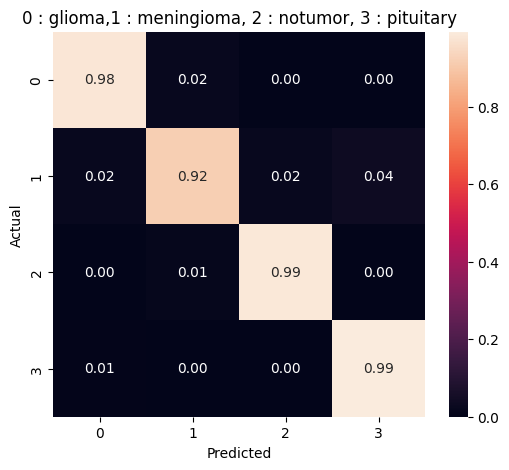

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(Y_test, Pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0 : glioma,1 : meningioma, 2 : notumor, 3 : pituitary')
plt.show(block=False)

In [98]:
from keras import models
from numpy import loadtxt
from tensorflow.keras.models import save_model
save_model(cnn, "ResNet502.h5")
# load and evaluate a saved model
loaded_model = models.load_model('ResNet502.h5')
# summarize model.
model=loaded_model
train_pred_p=model.predict(X_train)
train_pred = np.argmax(train_pred_p, axis=1)

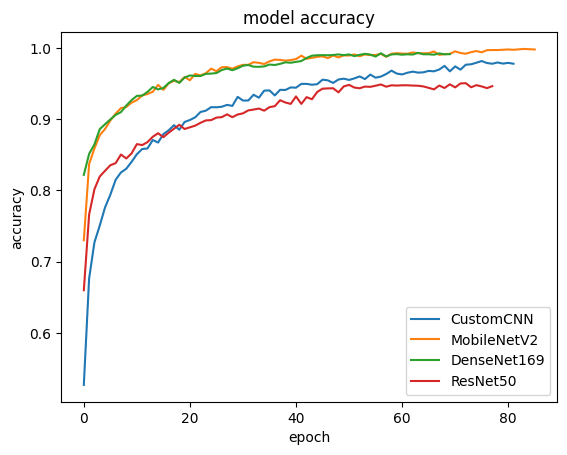

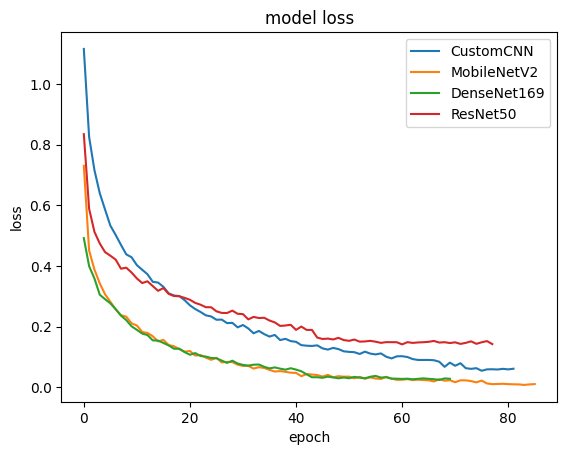

In [99]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history4.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CustomCNN', 'MobileNetV2','DenseNet169','ResNet50'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['CustomCNN', 'MobileNetV2','DenseNet169','ResNet50'], loc='upper right')
plt.show()

# ENSEMBLE

To create an ensemble of the four models, we will stack their predictions and use Microsoft FLAML AutoML to find an optimal combiner.

In [112]:
X_data=np.concatenate([pred1,pred2,pred3,pred4], axis=1)
y_data= np.argmax(y_test, axis=1)
X_data.shape, y_data.shape

((703, 16), (703,))

In [120]:
acc1=accuracy_score(np.argmax(pred1, axis=1),np.argmax(y_test, axis=1))
acc2=accuracy_score(np.argmax(pred2, axis=1),np.argmax(y_test, axis=1))
acc3=accuracy_score(np.argmax(pred3, axis=1),np.argmax(y_test, axis=1))
acc4=accuracy_score(np.argmax(pred4, axis=1),np.argmax(y_test, axis=1))
accuracy_score(np.argmax(pred1, axis=1),np.argmax(y_test, axis=1))

0.968705547652916

In [119]:
y_test

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [113]:
from flaml import AutoML
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 1000,  # total running time in seconds
    "task": 'classification',  # task type
    "seed": 24545678,  # random seed
    "metric" : 'accuracy'}

automl.fit(X_train=X_data, y_train=y_data, **automl_settings)

[flaml.automl.logger: 04-25 17:06:59] {1679} INFO - task = classification
[flaml.automl.logger: 04-25 17:06:59] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 04-25 17:06:59] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-25 17:06:59] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 04-25 17:06:59] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-25 17:06:59] {2344} INFO - Estimated sufficient time budget=789s. Estimated necessary time budget=18s.
[flaml.automl.logger: 04-25 17:06:59] {2391} INFO -  at 0.1s,	estimator lgbm's best error=0.0398,	best estimator lgbm's best error=0.0398
[flaml.automl.logger: 04-25 17:06:59] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-25 17:07:00] {2391} INFO -  at 0.2s,	estimator lgbm's best error=0.0398,	best estimator lgbm's best error=0.0398
[flaml.automl.logger: 04-25 17:07:0

[flaml.automl.logger: 04-25 17:07:03] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 04-25 17:07:03] {2391} INFO -  at 3.8s,	estimator lgbm's best error=0.0242,	best estimator lgbm's best error=0.0242
[flaml.automl.logger: 04-25 17:07:03] {2218} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 04-25 17:07:03] {2391} INFO -  at 3.9s,	estimator lgbm's best error=0.0242,	best estimator lgbm's best error=0.0242
[flaml.automl.logger: 04-25 17:07:03] {2218} INFO - iteration 36, current learner xgboost
[flaml.automl.logger: 04-25 17:07:03] {2391} INFO -  at 4.0s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0242
[flaml.automl.logger: 04-25 17:07:03] {2218} INFO - iteration 37, current learner rf
[flaml.automl.logger: 04-25 17:07:03] {2391} INFO -  at 4.1s,	estimator rf's best error=0.0370,	best estimator lgbm's best error=0.0242
[flaml.automl.logger: 04-25 17:07:03] {2218} INFO - iteration 38, current learner rf
[flaml.automl

[flaml.automl.logger: 04-25 17:07:10] {2391} INFO -  at 10.7s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:10] {2218} INFO - iteration 71, current learner xgboost
[flaml.automl.logger: 04-25 17:07:10] {2391} INFO -  at 10.8s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:10] {2218} INFO - iteration 72, current learner xgboost
[flaml.automl.logger: 04-25 17:07:10] {2391} INFO -  at 11.0s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:10] {2218} INFO - iteration 73, current learner xgboost
[flaml.automl.logger: 04-25 17:07:11] {2391} INFO -  at 11.2s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:11] {2218} INFO - iteration 74, current learner xgboost
[flaml.automl.logger: 04-25 17:07:11] {2391} INFO -  at 11.4

[flaml.automl.logger: 04-25 17:07:18] {2391} INFO -  at 18.7s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:18] {2218} INFO - iteration 106, current learner xgb_limitdepth
[flaml.automl.logger: 04-25 17:07:18] {2391} INFO -  at 18.8s,	estimator xgb_limitdepth's best error=0.0299,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:18] {2218} INFO - iteration 107, current learner xgb_limitdepth
[flaml.automl.logger: 04-25 17:07:18] {2391} INFO -  at 19.1s,	estimator xgb_limitdepth's best error=0.0284,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:18] {2218} INFO - iteration 108, current learner xgboost
[flaml.automl.logger: 04-25 17:07:19] {2391} INFO -  at 19.4s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:19] {2218} INFO - iteration 109, current learner xgb_limitdepth
[flaml.automl.logger:

[flaml.automl.logger: 04-25 17:07:27] {2218} INFO - iteration 140, current learner rf
[flaml.automl.logger: 04-25 17:07:27] {2391} INFO -  at 27.4s,	estimator rf's best error=0.0270,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:27] {2218} INFO - iteration 141, current learner xgboost
[flaml.automl.logger: 04-25 17:07:27] {2391} INFO -  at 27.7s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:27] {2218} INFO - iteration 142, current learner rf
[flaml.automl.logger: 04-25 17:07:27] {2391} INFO -  at 27.9s,	estimator rf's best error=0.0270,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:27] {2218} INFO - iteration 143, current learner xgboost
[flaml.automl.logger: 04-25 17:07:27] {2391} INFO -  at 28.0s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:27] {2218} INFO - iteration 144, current l

/opt/anaconda3/envs/Project/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/Project/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/Project/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/Project/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 04-25 17:07:33] {2391} INFO -  at 33.2s,	estimator lrl1's best error=0.0256,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:33] {2218} INFO - iteration 169, current learner lrl1
[flaml.automl.logger: 04-25 17:07:33] {2391} INFO -  at 33.3s,	estimator lrl1's best error=0.0256,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:33] {2218} INFO - iteration 170, current learner rf
[flaml.automl.logger: 04-25 17:07:33] {2391} INFO -  at 33.5s,	estimator rf's best error=0.0270,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:33] {2218} INFO - iteration 171, current learner rf
[flaml.automl.logger: 04-25 17:07:33] {2391} INFO -  at 33.6s,	estimator rf's best error=0.0270,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:33] {2218} INFO - iteration 172, current learner rf
[flaml.automl.logger: 04-25 17:07:33] {2391} INFO -  at 33.9s,	estimator rf's best error=0

[flaml.automl.logger: 04-25 17:07:42] {2218} INFO - iteration 204, current learner xgboost
[flaml.automl.logger: 04-25 17:07:43] {2391} INFO -  at 43.4s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:43] {2218} INFO - iteration 205, current learner xgboost
[flaml.automl.logger: 04-25 17:07:43] {2391} INFO -  at 43.9s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:43] {2218} INFO - iteration 206, current learner xgboost
[flaml.automl.logger: 04-25 17:07:44] {2391} INFO -  at 44.4s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:44] {2218} INFO - iteration 207, current learner xgboost
[flaml.automl.logger: 04-25 17:07:44] {2391} INFO -  at 44.7s,	estimator xgboost's best error=0.0199,	best estimator xgboost's best error=0.0199
[flaml.automl.logger: 04-25 17:07:44] {2218} INFO - iter

[flaml.automl.logger: 04-25 17:07:56] {2391} INFO -  at 56.4s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:07:56] {2218} INFO - iteration 240, current learner xgboost
[flaml.automl.logger: 04-25 17:07:56] {2391} INFO -  at 56.9s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:07:56] {2218} INFO - iteration 241, current learner xgboost
[flaml.automl.logger: 04-25 17:07:57] {2391} INFO -  at 57.2s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:07:57] {2218} INFO - iteration 242, current learner rf
[flaml.automl.logger: 04-25 17:07:57] {2391} INFO -  at 57.4s,	estimator rf's best error=0.0256,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:07:57] {2218} INFO - iteration 243, current learner xgboost
[flaml.automl.logger: 04-25 17:07:57] {2391} INFO -  at 57.9s,	est

[flaml.automl.logger: 04-25 17:08:12] {2218} INFO - iteration 274, current learner xgboost
[flaml.automl.logger: 04-25 17:08:13] {2391} INFO -  at 73.8s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:08:13] {2218} INFO - iteration 275, current learner xgboost
[flaml.automl.logger: 04-25 17:08:14] {2391} INFO -  at 74.8s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:08:14] {2218} INFO - iteration 276, current learner xgboost
[flaml.automl.logger: 04-25 17:08:14] {2391} INFO -  at 75.1s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:08:14] {2218} INFO - iteration 277, current learner xgboost
[flaml.automl.logger: 04-25 17:08:15] {2391} INFO -  at 75.3s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:08:15] {2218} INFO - iter

[flaml.automl.logger: 04-25 17:08:30] {2218} INFO - iteration 308, current learner xgboost
[flaml.automl.logger: 04-25 17:08:30] {2391} INFO -  at 91.1s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:08:30] {2218} INFO - iteration 309, current learner xgboost
[flaml.automl.logger: 04-25 17:08:31] {2391} INFO -  at 91.6s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:08:31] {2218} INFO - iteration 310, current learner rf
[flaml.automl.logger: 04-25 17:08:31] {2391} INFO -  at 91.9s,	estimator rf's best error=0.0256,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:08:31] {2218} INFO - iteration 311, current learner xgboost
[flaml.automl.logger: 04-25 17:08:32] {2391} INFO -  at 92.3s,	estimator xgboost's best error=0.0185,	best estimator xgboost's best error=0.0185
[flaml.automl.logger: 04-25 17:08:32] {2218} INFO - iteration 312,

In [114]:
pred5=automl.predict(X_data)

In [124]:
acc1=accuracy_score(np.argmax(pred1, axis=1),np.argmax(y_test, axis=1))
acc2=accuracy_score(np.argmax(pred2, axis=1),np.argmax(y_test, axis=1))
acc3=accuracy_score(np.argmax(pred3, axis=1),np.argmax(y_test, axis=1))
acc4=accuracy_score(np.argmax(pred4, axis=1),np.argmax(y_test, axis=1))
acc5=accuracy_score(pred5,np.argmax(y_test, axis=1))
acc1,acc2,acc3,acc4,acc5

(0.968705547652916,
 0.9445234708392604,
 0.9274537695590327,
 0.9274537695590327,
 0.9985775248933144)

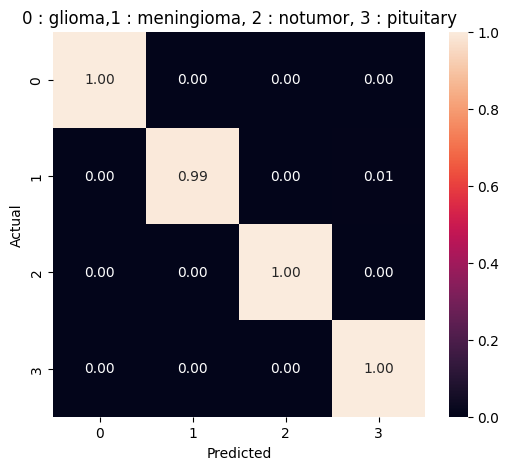

In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
cm = confusion_matrix(y_data, pred5)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('0 : glioma,1 : meningioma, 2 : notumor, 3 : pituitary')
plt.show(block=False)

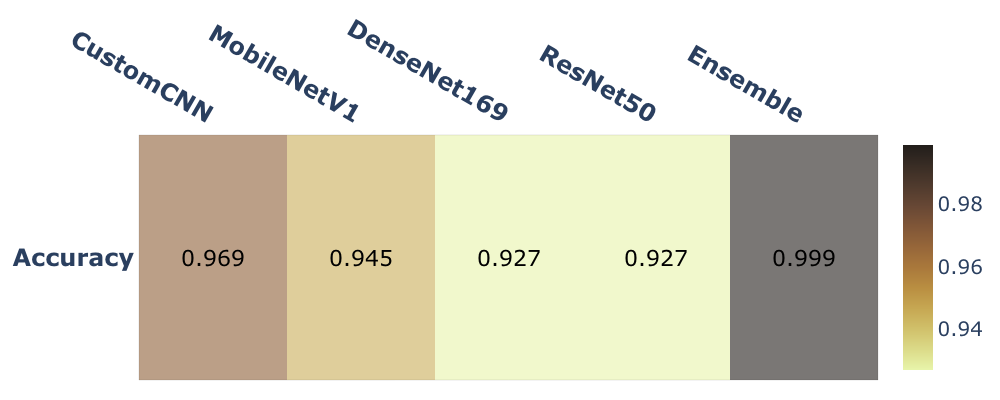

In [129]:
import numpy as np
import plotly.graph_objects as go
from functools import reduce
from itertools import product
from IPython.display import Image
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
z=[ [np.round(acc1,3),np.round(acc2,3),np.round(acc3,3),np.round(acc4,3),np.round(acc5,3)]]
x=['<b>CustomCNN</b>', '<b>MobileNetV1</b>', '<b>DenseNet169</b>', '<b>ResNet50</b>', '<b>Ensemble</b>']
y=['<b>Accuracy</b>']

def get_anno_text(z_value):
    annotations=[]
    a, b = len(z_value), len(z_value[0])
    flat_z = reduce(lambda x,y: x+y, z_value) # z_value.flat if you deal with numpy
    coords = product(range(a), range(b))
    for pos, elem in zip(coords, flat_z):
        annotations.append({'font': {'color': 'black'},
                    'showarrow': False,
                    'text': str(elem),
                    'x': pos[1],
                    'y': pos[0],
                        'font.size':22   })
    return annotations

fig = go.Figure(data=go.Heatmap(
                   z=z,
                   x=x,
                   y=y,
                   hoverongaps = True, colorscale ='turbid',
    opacity=0.6,colorbar=dict(tickfont=dict(size=20)) ))#matter#

fig.update_layout(title={'text': "",
        'y':0.8,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
           plot_bgcolor='rgba(0,0,0,0)',       
    annotations = get_anno_text(z),
                 width=1000,
height=400,xaxis={'side': 'top'},margin=dict(l=20, r=20, t=20, b=20))

fig.update_xaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
    
                 mirror=True)
fig.update_yaxes(tickfont = dict(size=24),linewidth=0.1, linecolor='black',
        
                 mirror=True)
fig.write_image("table2b.png",engine="kaleido")
#plt.savefig("table2a.pdf", format="pdf", bbox_inches="tight")
fig.show()
Image('table2b.png')